<a href="https://colab.research.google.com/github/FatherOfLove/RL/blob/main/RL_stock_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random


from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
stock_data1 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/VCYT.csv'))
stock_data2 =  pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/AMD.csv'))
stock_data3 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/AAPL.csv'))
stock_data4 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/NSTG.csv'))
stock_data5 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/NIO.csv'))
stock_data6 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/JYNT.csv'))
stock_data7 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/NQSDA.csv'))
stock_data8 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/KODK.csv'))

In [3]:
NQSDA_Index =  [] 

stock_data7 = stock_data7[stock_data7["Date"].isin(stock_data8.Date.values)]
amount_stock_NQSDA = 100000/stock_data7.Close[0]
for price in stock_data7['Close'].tolist() : 
  NQSDA_Index.append(amount_stock_NQSDA *price)

In [4]:
df = stock_data3
print(df.head())

         Date       Open       High        Low      Close  Adj Close     Volume
0  2018-01-02  42.540001  43.075001  42.314999  43.064999  41.105534  102223600
1  2018-01-03  43.132500  43.637501  42.990002  43.057499  41.098373  118071600
2  2018-01-04  43.134998  43.367500  43.020000  43.257500  41.289268   89738400
3  2018-01-05  43.360001  43.842499  43.262501  43.750000  41.759361   94640000
4  2018-01-08  43.587502  43.902500  43.482498  43.587502  41.604263   82271200


No handles with labels found to put in legend.


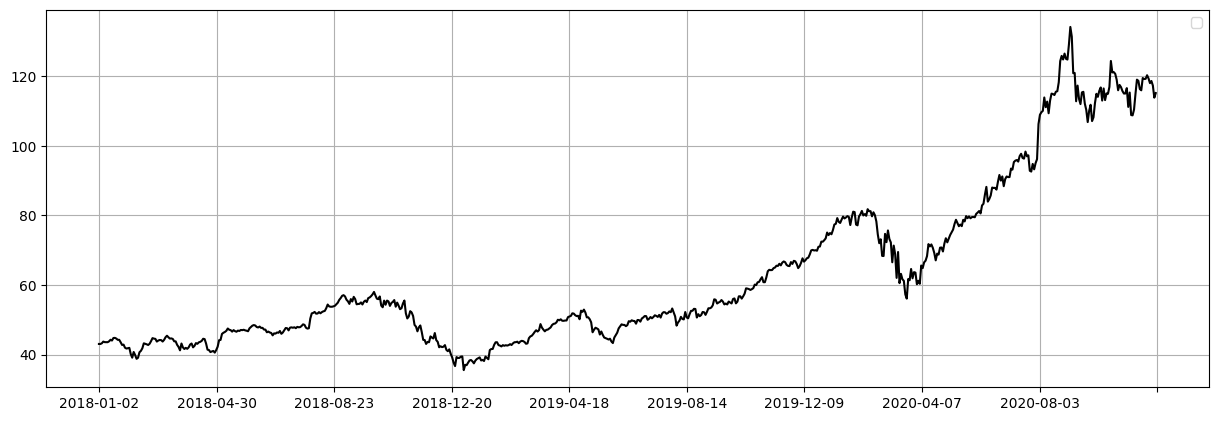

In [5]:
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df['Date'], df['Close'], color='black')
plt.xticks(np.linspace(0, len(df), 10))
plt.legend()
plt.grid()

In [6]:
df=df.sort_values('Date', ascending=True).reset_index(drop=True)

# caculate MA（moving avarage price）
for day in [5, 10, 21, 30]:
    df['ma'+str(day)] = df.Close.rolling(day).mean()

col = ['ma5', 'ma10', 'ma21', 'ma30']
tmp_df2 = df[col].shift(1)
tmp_df3 = df[col].shift(2)
for tmp_col in col:
    df[tmp_col + '_trend'] = 0
    # tmp_df[tmp_col + '_shift_1'] = tmp_df2[tmp_col]
    # tmp_df[tmp_col _ 'shift_2'] = tmp_df3[tmp_col]
    df['rate1'] = (tmp_df2[tmp_col] - tmp_df3[tmp_col]) / (tmp_df3[tmp_col] + 0.00001)
    df['rate2'] = (df[tmp_col] - tmp_df2[tmp_col]) / (tmp_df2[tmp_col] + 0.00001)
    idx = (df['rate1'] > 0.005) & (df['rate2'] > 0.005)
    df.loc[idx, tmp_col + '_trend'] = 1 # trend going up

    idx = (df['rate1'] < -0.005) & (df['rate2'] < -0.005)
    df.loc[idx, tmp_col + '_trend'] = 2 # # trend going down



df = df.loc[31:].reset_index(drop=True)
df_copy = df.copy()

In [7]:
df_copy

,Date,Open,High,Low,Close,Adj Close,Volume,ma5,ma10,ma21,ma30,ma5_trend,rate1,rate2,ma10_trend,ma21_trend,ma30_trend
0,2018-02-15,42.447498,43.272499,42.250000,43.247501,41.448032,204588800,41.191000,40.463250,41.872262,42.466083,1,-0.000959,0.000149,0,0,0
1,2018-02-16,43.090000,43.705002,42.942501,43.107498,41.313858,160704400,41.992000,40.761500,41.790952,42.461083,1,0.000149,-0.000118,0,0,0
2,2018-02-20,43.012501,43.564999,42.855000,42.962502,41.174889,135722000,42.449000,41.145500,41.712262,42.434833,1,-0.000118,-0.000618,1,0,0
3,2018-02-21,43.207500,43.529999,42.752499,42.767502,40.988007,149886400,42.785500,41.346500,41.641667,42.407500,1,-0.000618,-0.000644,0,0,0
4,2018-02-22,42.950001,43.487499,42.927502,43.125000,41.330627,123967600,43.042001,41.670500,41.587619,42.392250,1,-0.000644,-0.000360,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2020-11-18,118.610001,119.820000,118.000000,118.029999,118.029999,76322100,119.238000,118.569000,115.930476,116.879667,0,0.001781,0.000842,0,0,0
696,2020-11-19,117.589996,119.059998,116.809998,118.639999,118.639999,74113000,119.124000,118.530000,116.014762,117.002000,0,0.000842,0.001047,0,0,0
697,2020-11-20,118.639999,118.769997,117.290001,117.339996,117.339996,73391400,118.739999,118.395000,116.090476,117.014333,0,0.001047,0.000105,0,0,0
698,2020-11-23,117.180000,117.620003,113.750000,113.849998,113.849998,127959300,117.449998,118.147999,116.033809,116.662667,0,0.000105,-0.003005,0,0,0


In [8]:
#todo: Position control strategy
# https://www.investopedia.com/articles/trading/10/create-trading-strategies.asp

def compute_score(index_df, i):
    score = 0
    tmp_rate = (index_df['Close'][i]-index_df['ma5'][i])
    if tmp_rate>=0:
        score += 1
        
    tmp_rate = (index_df['Close'][i]-index_df['ma10'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5
    
    tmp_rate = (index_df['Close'][i]-index_df['ma21'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5

    tmp_rate = (index_df['Close'][i]-index_df['ma30'][i])
    if tmp_rate>=0:
        score += 1
    elif tmp_rate>-0.5:
        score += 0.5
    
    if index_df['ma5_trend'][i] == 1:
        score += 1
    
    if index_df['ma10_trend'][i] == 1:
        score += 1.5
    elif index_df['ma10_trend'][i] == 0:
        score += 0.5

    if index_df['ma21_trend'][i] == 1:
        score += 1.5
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    if index_df['ma21_trend'][i] == 1:
        score += 1
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    return score

# Manual strategy

def print_info(hold_money, hold_market_value, index_df, i, kind, change_amount):
    trade_date = index_df['Date'][i]
    change_amount = round(change_amount,2)
    rate = (index_df['Close'][i] - index_df['Close'][i-1]) / index_df['Close'][i-1]
    rate = round(rate, 2)
    info = str(trade_date)
    if rate > 0:
        info += ', going up ' + str(rate)
    else:
        info += ', going down ' + str(rate)
        
    if kind == 1:
        info += ', buy ' + str(change_amount) 
    
    elif kind == 2:
        info += ', sell ' + str(change_amount) 
    
    info += ',hold money：'+str(round(hold_money,2))+',stocks_value：'+\
    str(round(hold_market_value,2))+',total_market_value：'+str(round(hold_money+hold_market_value,2))
    print(info)


score_list = []
hold_mount = 0
money_init = 100000
hold_money = money_init
hold_market_value = 0
hold_market_value_list = []
hold_money_list = []
all_value_list_manual = []
change_amount = 0
for i in range(len(df)):
    score = compute_score(df, i) / 10    
    #print(str(score))
    if i == 0:
        buy_money = int(money_init * score)
        hold_market_value = buy_money
        hold_money = hold_money - buy_money
        print(str(df['Date'][i])+'buy：'+str(str(buy_money)))
        print(hold_market_value)
    else:
        hold_market_value = hold_market_value * df['Close'][i]/df['Close'][i-1]
        print(hold_market_value)
        if score_list[-1] == score:
            kind = 0
            
        elif score_list[-1] < score: #buy
            if score_list[-1] == 0:
                add_mount = score
            else:
                add_mount = score - score_list[-1]
            
            buy_money = int(hold_money/(1-score_list[-1])* (add_mount))
            hold_market_value += buy_money
            hold_money -= buy_money
            kind = 1
            change_amount = add_mount
            
        else: #sell
            reduce_mount =  score_list[-1] - score
            sell_money = int(hold_market_value/score_list[-1] * (reduce_mount))
            hold_market_value -= sell_money
            hold_money += sell_money
            change_amount = sell_money
            kind = 2
            
        print_info(hold_money, hold_market_value, df, i, kind, change_amount) 
        
    score_list.append(score)
    hold_market_value_list.append(hold_market_value)
    hold_money_list.append(hold_money)
    all_value_list_manual.append(hold_money+hold_market_value)

2018-02-15buy：75000
75000
74757.20620250405
2018-02-16, going down -0.0,hold money：25000,stocks_value：74757.21,total_market_value：99757.21
74505.75352319202
2018-02-20, going down -0.0, buy 0.1,hold money：15001,stocks_value：84504.75,total_market_value：99505.75
84121.19981542559
2018-02-21, going down -0.0, sell 19793,hold money：34794,stocks_value：64328.2,total_market_value：99122.2
64865.92593227045
2018-02-22, going up 0.01, buy 0.1,hold money：24853,stocks_value：74806.93,total_market_value：99659.93
76107.91594848385
2018-02-23, going up 0.02,hold money：24853,stocks_value：76107.92,total_market_value：100960.92
77612.72773390402
2018-02-26, going up 0.02,hold money：24853,stocks_value：77612.73,total_market_value：102465.73
77361.20299743609
2018-02-27, going down -0.0, buy 0.1,hold money：14912,stocks_value：87302.2,total_market_value：102214.2
87170.06585960259
2018-02-28, going down -0.0,hold money：14912,stocks_value：87170.07,total_market_value：102082.07
85643.17240064645
2018-03-01, going d

# Q-learning

In [9]:
class Agent:
    def __init__(self, state_size, window_size, trend, frequency, batch_size , gamma = 0.98,epsilon = 0.5, epsilon_min = 0.03,epsilon_decay = 0.999, lr =0.00001):
        self.state_size = state_size #size of the state
        self.window_size = window_size #window size, buy stop before the window size days
        self.half_window = window_size // 2
        self.trend = trend  #data
        self.frequency = frequency 
        self.action_size = 3 #there are three action: buy, sell and hold
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000) 
        self.inventory = [] 

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay


        tf.compat.v1.reset_default_graph()
        #tf.reset_default_graph()
        self.sess = tf.compat.v1.InteractiveSession()
        tf.compat.v1.disable_eager_execution()
        #self.sess = tf.InteractiveSession() 
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size]) #state
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size]) #action
        #print(self.X)
        feed = tf.keras.layers.Dense(256, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(128, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(64, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(32, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(16, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(8, activation ='relu')(self.X)
        self.logits = tf.keras.layers.Dense( self.action_size)(feed) #calulate the prob of 3 different action
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits)) #calculate the loss function
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(self.cost) 
        self.total_money_list=[]
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def act(self, state, is_test=False): #choose action
        if not is_test:
          if random.random() <= self.epsilon: #if less than epsilon will use random range
            return random.randrange(self.action_size)
		#else choose the best action
        return np.argmax( 
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t): #get the state in time t
        window_size = self.window_size + 1
        d = t - window_size + 1
		    #initial window size not enough, use 0 instead of window size
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i]) #reward of each step
        return np.array([res]) #assign state 

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])#memory
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        
		#Q calulate
		#[state, action, reward, next_state, done]
		# initial Q table
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
		#update Q table
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done: 
                target[action] += self.gamma * np.amax(Q_new[i])
			
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
		#adjust the epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        #print(Q)
        return cost

    def test(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = [] 
        market_value = initial_money
        hold_money = initial_money
        stock_value = 0
        hold_num = 0
        self.total_money_list.append(initial_money)
        state = self.get_state(0) 
        for t in range(0, len(self.trend) - 1):
            if t%self.frequency!=0 :
              stock_value = self.trend[t] * hold_num *100
              market_value = stock_value + hold_money 
              self.total_money_list.append(market_value)
              continue                           
            action = self.act(state, True) #do action base on state
            next_state = self.get_state(t + 1) #get next state
            #action=1 buy
            if action == 1 and hold_money >= self.trend[t]*100 and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t]) #buy
                #initial_money -= self.trend[t] 
                buy_num = int(hold_money // self.trend[t] // 100)
                hold_num += buy_num
                stock_value += self.trend[t]*100 * buy_num
                hold_money -= self.trend[t]*100 * buy_num

                states_buy.append(t) #record the transcation 
                print('day %d: buy %d unit at price %f'% (t,buy_num, self.trend[t]))
                
            #action=2 sell
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0) #sell
                #initial_money += self.trend[t] 
                states_sell.append(t) #record the transcation 
                hold_money += self.trend[t] * hold_num * 100          
                stock_value =0  
                market_value = stock_value + hold_money
              	#calculate the invest
                try: 
                    invest = ((self.trend[t] - bought_price) / bought_price) 
                except:
                    invest = 0
                    
                print(
                    'day %d, sell %d unit at price %f, investment %f %%, total balance %f,'
                      % (t, hold_num, self.trend[t], invest, market_value)
                )
                hold_num = 0
            
            stock_value = self.trend[t] * hold_num *100
            market_value = stock_value + hold_money
            total_profit = market_value - initial_money
            #invest = ((market_value - initial_money) / initial_money)

            # self.memory.append((state, action, invest, 
            #                         next_state, starting_money < initial_money))
                                 
            self.total_money_list.append(market_value)
            state = next_state 

		#calculate the invest
        invest_all = ((market_value - starting_money) / starting_money)* 100
        total_gains = market_value - starting_money
        
        return states_buy, states_sell, total_gains, invest_all
        
    def train(self, iterations, checkpoint, initial_money):
		
        for i in range(iterations):
            #print(str(i))
            total_profit = 0 
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            last_value = initial_money
            market_value = initial_money
            hold_money = initial_money
            stock_value = 0
            hold_num = 0

            for t in range(0, len(self.trend) - 1, self.frequency):
                #print(str(i),t)
                action = self.act(state)
                next_state = self.get_state(t + 1)
                #print(next_state)
                if action == 1 and hold_money >= self.trend[t]*100 and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    buy_num = int(hold_money// self.trend[t] // 100)#buy stock number
                    hold_num += buy_num
                    stock_value += self.trend[t]*100 * buy_num
                    hold_money -= self.trend[t]*100 * buy_num
                    #print(stock_value,hold_money)
                
                elif action == 2 and len(inventory) > 0:
                    # bought_price = inventory.pop(0)
                    # total_profit += self.trend[t] - bought_price
                    # starting_money += self.trend[t]
                    hold_money += self.trend[t]* hold_num*100 
                    hold_num = 0
                    stock_value = 0
                    #print(stock_value,hold_money)
                    
                stock_value = self.trend[t] * hold_num *100
                market_value = stock_value + hold_money
                total_profit = market_value - initial_money
                invest = ((market_value - last_value) / last_value)
                last_value = market_value
                #print(stock_value,market_value,total_profit,invest,last_value)

                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                #print(self.batch_size)
                batch_size = min(self.batch_size, len(self.memory))
                #print(batch_size)
                cost = self.replay(batch_size)
                #print(cost)
            
            if (i+1) % checkpoint == 0:
                invest_all = ((market_value - initial_money) / initial_money)
                #if invest_all > 1.0:
                #    break  
                print('epoch: %d, total rewards: %f, cost: %f, total money: %f'%(i + 1, total_profit, cost, market_value))

In [10]:
def back_test(df,initial_money,window_size,frequency,batch_size,iterations,checkpoint,gamma = 0.98,epsilon = 0.5, epsilon_min = 0.03,epsilon_decay = 0.999, lr =0.02): 
    trend = df.Close.values.tolist() #using close price to test  
    agent_Q = Agent(state_size = window_size, 
                  window_size = window_size, 
                  trend = trend, 
                  frequency = frequency, 
                  batch_size = batch_size,
                  gamma = gamma,
                  epsilon = epsilon, 
                  epsilon_min = epsilon_min,
                  epsilon_decay = epsilon_decay, 
                  lr = lr)
    agent_Q.train(iterations = iterations, checkpoint = checkpoint, initial_money = initial_money)
       

    states_buy, states_sell, total_gains, invest = agent_Q.test(initial_money = initial_money)
    
    
   
    fig = plt.figure(figsize = (15,5))
    plt.plot(trend, color='r', lw=2.)
    plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('gamma: %.3f,epsilon: %.3f,epsilon_min: %.3f,epsilon_decay: %.3f,lr: %.6f\n'%(gamma,epsilon,epsilon_min,epsilon_decay,lr)+'total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

     #buy first day and hold strategy
    buy_hold_strategy_value =  [] 
    amount_stock = initial_money/trend[0]
    for price in trend : 
      buy_hold_strategy_value.append(amount_stock *price)
    #print(len(buy_hold_strategy_value))
    #print(len(agent.total_money_list))

    fig = plt.figure(figsize = (15,5))
    plt.plot(buy_hold_strategy_value, color='r', lw=2.,label="buy_hold_strategy%.1f"%(buy_hold_strategy_value[-1]))
    plt.plot(all_value_list_manual, color='y', lw=2.,label="Manual strategy%.1f"%(all_value_list_manual[-1]))
    plt.plot(agent_Q.total_money_list, color='b', lw=2.,label="QL_agent_value%.1f"%(agent_Q.total_money_list[-1]))
    plt.plot(NQSDA_Index, color='g', lw=2.,label="NQSDA_value" )
    plt.plot()
    plt.ylabel("total value")
    plt.xlabel("day")
    plt.legend()
    plt.show()

epoch: 10, total rewards: 9930.000300, cost: 0.300584, total money: 109930.000300
epoch: 20, total rewards: 24341.250100, cost: 0.311734, total money: 124341.250100
epoch: 30, total rewards: 9707.252100, cost: 0.300006, total money: 109707.252100
epoch: 40, total rewards: 197.998400, cost: 0.309934, total money: 100197.998400
epoch: 50, total rewards: 9930.000300, cost: 0.288438, total money: 109930.000300
epoch: 60, total rewards: 9930.000300, cost: 0.283718, total money: 109930.000300
epoch: 70, total rewards: 9930.000300, cost: 0.289322, total money: 109930.000300
epoch: 80, total rewards: 9930.000300, cost: 0.281456, total money: 109930.000300
epoch: 90, total rewards: 10915.500300, cost: 0.329466, total money: 110915.500300
epoch: 100, total rewards: 12437.995500, cost: 0.272434, total money: 112437.995500
epoch: 110, total rewards: 9930.000300, cost: 0.274979, total money: 109930.000300
epoch: 120, total rewards: 9930.000300, cost: 0.273105, total money: 109930.000300
epoch: 130,

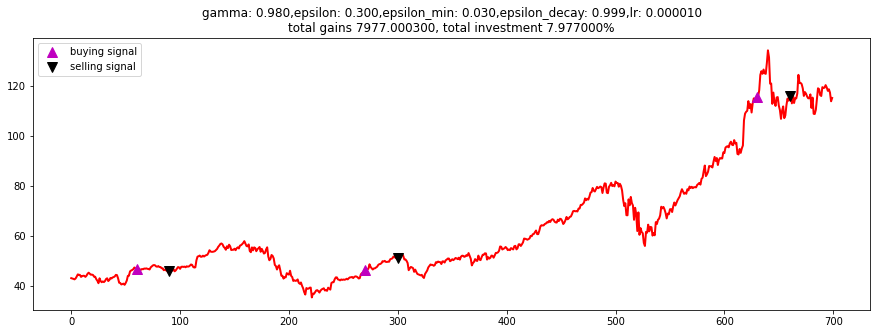

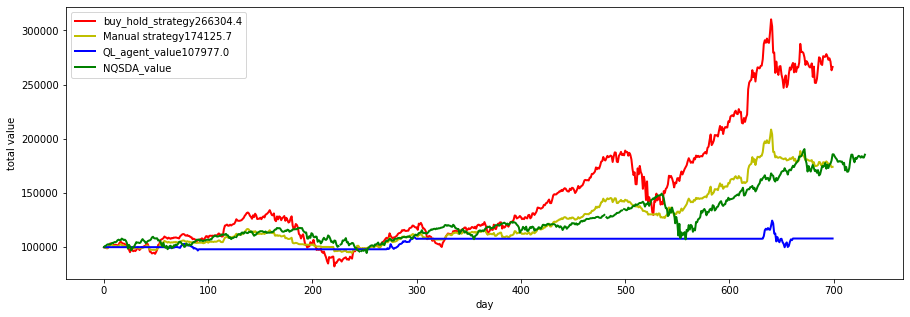

In [11]:
back_test(df,initial_money = 100000, window_size = 5, frequency = 30, batch_size = 32,iterations = 2000, checkpoint = 10,gamma = 0.98,epsilon = 0.3, epsilon_min = 0.03,epsilon_decay = 0.999, lr =0.00001)

In [12]:
len(df_copy)

700